### Train static models for in hospital mortality risk prediction

## Imports

In [7]:
import os
import random
import sys
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

from drift_detection.baseline_models.static.utils import run_model
from drift_detection.drift_detector.plotter import plot_roc, plot_pr, errorfill, linestyles, markers, colorscale, colors, brightness
from drift_detection.baseline_models.static.utils import run_model
from drift_detection.gemini.utils import *

## Parameters

In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
TIMESTEPS = 6
AGGREGATION_TYPE = "time_flatten"
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW", "PMH","SBK"]
OUTCOME = "mortality"
THRESHOLD=0.05

## Query and process data

In [3]:
SHIFT = input("Select experiment: ")  # hospital_type

admin_data, x, y = get_gemini_data(PATH)

(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITALS)

# Normalize data
X_tr_normalized  = normalize(admin_data, X_tr, AGGREGATION_TYPE,TIMESTEPS)
X_val_normalized = normalize(admin_data, X_val, AGGREGATION_TYPE, TIMESTEPS)
X_t_normalized = normalize(admin_data, X_t, AGGREGATION_TYPE, TIMESTEPS)

y_tr = get_label(admin_data, X_tr, OUTCOME)
y_val = get_label(admin_data, X_val, OUTCOME)
y_t = get_label(admin_data, X_t, OUTCOME)

# Scale data
X_tr_scaled = scale(X_tr_normalized)
X_val_scaled = scale(X_val_normalized)
X_t_scaled = scale(X_t_normalized)

# Process data
X_tr_final = process(X_tr_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_val_final = process(X_val_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_t_final = process(X_t_scaled, AGGREGATION_TYPE, TIMESTEPS)

Select experiment:  covid


2022-10-14 11:21:45,881 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-10-14 11:21:46,307 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-10-14 11:21:46,476 INFO cyclops.feature_handler - Loading features from file...
2022-10-14 11:21:46,485 INFO cyclops.feature_handler - Found file to load for static features...
2022-10-14 11:21:46,490 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-10-14 11:21:46,530 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-10-14 11:21:52,291 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-10-14 11:22:00,901 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


## Build Model

In [4]:
from drift_detection.baseline_models.static.utils import run_model

MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT, OUTCOME, '_'.join(HOSPITALS), MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_tr_final, y_tr, X_val_final, y_val)
    pickle.dump(optimised_model, open(MODEL_PATH, 'wb'))

Select Model:  xgb


## Performance ##

In [17]:
val_auroc = [] 
val_auprc = []
test_auroc = []
test_auprc = []

RANDOM_RUNS=10
for i in range(RANDOM_RUNS):
    
    random.seed(i)

    (X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITALS, i)

    # Normalize data
    X_tr_normalized  = normalize(admin_data, X_tr, AGGREGATION_TYPE,TIMESTEPS)
    X_val_normalized = normalize(admin_data, X_val, AGGREGATION_TYPE, TIMESTEPS)
    X_t_normalized = normalize(admin_data, X_t, AGGREGATION_TYPE, TIMESTEPS)

    # Get labels
    y_tr = get_label(admin_data, X_tr, OUTCOME)
    y_val = get_label(admin_data, X_val, OUTCOME)
    y_t = get_label(admin_data, X_t, OUTCOME)

    # Scale data
    X_tr_scaled = scale(X_tr_normalized)
    X_val_scaled = scale(X_val_normalized)
    X_t_scaled = scale(X_t_normalized)

    # Process data
    X_tr_final = process(X_tr_scaled, AGGREGATION_TYPE, TIMESTEPS)
    X_val_final = process(X_val_scaled, AGGREGATION_TYPE, TIMESTEPS)
    X_t_final = process(X_t_scaled, AGGREGATION_TYPE, TIMESTEPS)
    
    y_pred_prob = optimised_model.predict_proba(X_val_final)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    val_auroc.append(roc_auc)
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall, precision)
    val_auprc.append(auc_pr)
    
    y_pred_prob = optimised_model.predict_proba(X_t_final)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_t, y_pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    test_auroc.append(roc_auc)
    precision, recall, thresholds = precision_recall_curve(y_t, y_pred_prob)
    auc_pr = auc(recall, precision)
    test_auprc.append(auc_pr)

In [25]:
def get_bootstrapped_metric(bs_metric):
    bs_mean = np.round(np.mean(bs_metric),3)
    ci = st.t.interval(0.95, len(bs_metric)-1, loc=np.mean(bs_metric), scale=st.sem(bs_metric))
    mean_ci = str(bs_mean) + " [" + str(np.round(ci[0],3)) + " - " + str(np.round(ci[1],3)) + "]"
    return(mean_ci)

val_auroc_bs = get_bootstrapped_metric(val_auroc)
val_auprc_bs = get_bootstrapped_metric(val_auprc)
test_auroc_bs = get_bootstrapped_metric(test_auroc)
test_auprc_bs = get_bootstrapped_metric(test_auprc)

### Performance on Source Data ###

<AxesSubplot:title={'center':'PRC curve (area = 0.969 [0.949 - 0.99])'}, xlabel='Recall', ylabel='Precision'>

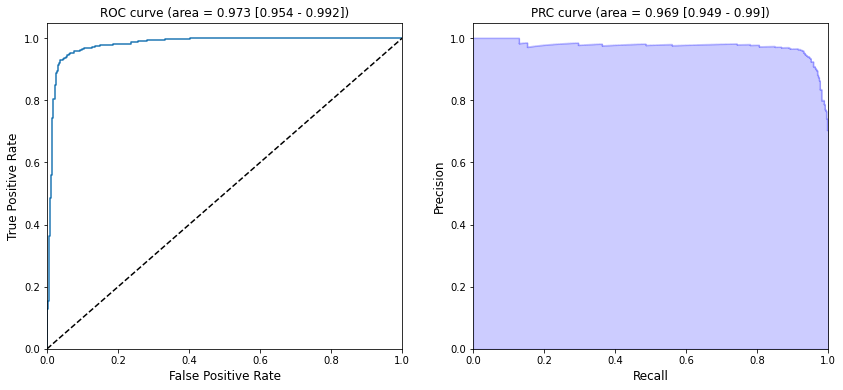

In [23]:
y_pred_prob = optimised_model.predict_proba(X_val_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_roc(ax[0], fpr, tpr, val_auroc_bs)
plot_pr(ax[1], recall, precision, val_auprc_bs)

### Performance on Target Data ###

<AxesSubplot:title={'center':'PRC curve (area = 0.914 [0.914 - 0.914])'}, xlabel='Recall', ylabel='Precision'>

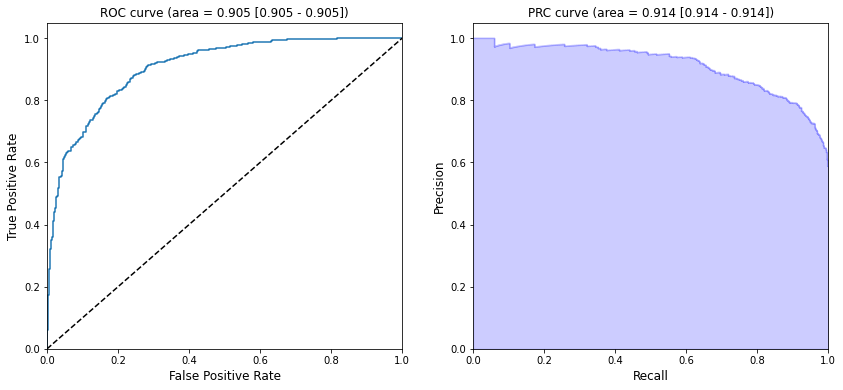

In [24]:
y_pred_prob = optimised_model.predict_proba(X_t_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_t, y_pred_prob, pos_label=1)
precision, recall, thresholds = precision_recall_curve(y_t, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_roc(ax[0], fpr, tpr, test_auroc_bs)
plot_pr(ax[1], recall, precision, test_auprc_bs)

## Get AUROC and AUPRC By Varying Sample Sizes in Test Set

In [19]:
SAMPLES = [10, 20, 50, 100, 200, 500, 1000]

RANDOM_RUNS=100
samp_metrics = np.ones((len(SAMPLES), RANDOM_RUNS, 2, 2)) * (-1)
for si, sample in enumerate(SAMPLES):
    for i in range(0, RANDOM_RUNS - 1):
        i = int(i)
        np.random.seed(i)
        X_val_shuffled, y_val_shuffled = unison_shuffled_copies(X_val_final, y_val)
        X_test_shuffled, y_test_shuffled = unison_shuffled_copies(X_t_final, y_t)

        y_val_pred_prob = optimised_model.predict_proba(X_val_shuffled[:sample])[:, 1]
        val_fpr, val_tpr, val_thresholds = roc_curve(
            y_val_shuffled[:sample], y_val_pred_prob[:sample], pos_label=1
        )
        val_roc_auc = auc(val_fpr, val_tpr)
        val_avg_pr = average_precision_score(y_val_shuffled[:sample], y_val_pred_prob[:sample])

        y_test_pred_prob = optimised_model.predict_proba(X_test_shuffled[:sample])[:, 1]
        test_fpr, test_tpr, test_thresholds = roc_curve(
            y_test_shuffled[:sample], y_test_pred_prob[:sample], pos_label=1
        )
        test_roc_auc = auc(test_fpr, test_tpr)
        test_avg_pr = average_precision_score(y_test_shuffled[:sample], y_test_pred_prob[:sample])

        samp_metrics[si, i, 0, :] = [val_roc_auc, val_avg_pr]
        samp_metrics[si, i, 1, :] = [test_roc_auc, test_avg_pr]

    mean_samp_metrics = np.mean(samp_metrics, axis=1)
    std_samp_metrics = np.std(samp_metrics, axis=1)

/mnt/nfs/home/subasriv/.cache/pypoetry/virtualenvs/cyclops-KKtuQLwg-py3.9/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/mnt/nfs/home/subasriv/.cache/pypoetry/virtualenvs/cyclops-KKtuQLwg-py3.9/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


## Plot Performance By Varying Sample Sizes in Test Set

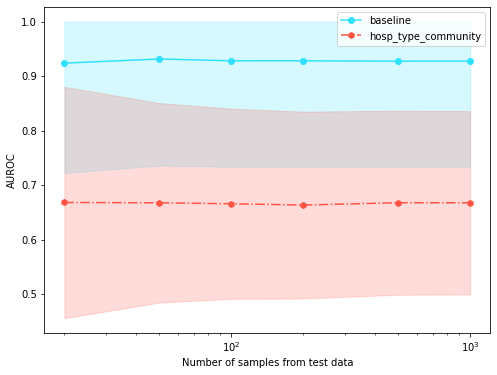

In [37]:
fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(["baseline", SHIFT]):
        errorfill(
                np.array(SAMPLES[1:]),
                mean_samp_metrics[1:, si, 0],
                std_samp_metrics[1:, si, 0],
                fmt=linestyles[si] + markers[si],
                color=colorscale(colors[si], brightness[si]),
                label="%s" % "_".join([shift]),
        )
plt.xlabel("Number of samples from test data")
plt.ylabel("AUROC")
plt.legend()
plt.show()

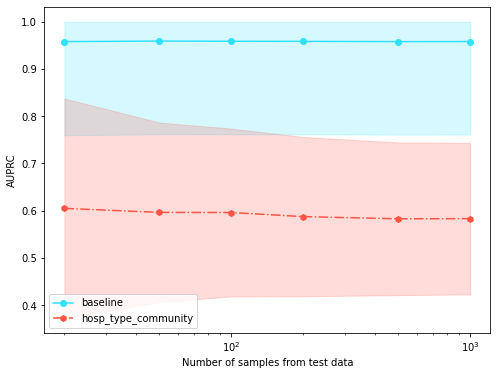

In [38]:
fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(["baseline", SHIFT]):
        errorfill(
                np.array(SAMPLES[1:]),
                mean_samp_metrics[1:, si, 1],
                std_samp_metrics[1:, si, 1],
                fmt=linestyles[si] + markers[si],
                color=colorscale(colors[si], brightness[si]),
                label="%s" % "_".join([shift]),
        )
plt.xlabel("Number of samples from test data")
plt.ylabel("AUPRC")
plt.legend()
plt.show()